# Model Prototyping
This notebook use to prototype the model for the task of predicting the stroke.

In [1]:
import pandas as pd

from stroke_prediction.config import PROCESSED_DATA_DIR

train_data = pd.read_csv(PROCESSED_DATA_DIR / "train-stroke-data.csv")
test_data = pd.read_csv(PROCESSED_DATA_DIR / "test-stroke-data.csv")

2025-05-26 19:59:01.699 | INFO     | stroke_prediction.config:<module>:11 - PROJ_ROOT path is: E:\Projects\stroke-prediction-api


In [2]:
from sklearn.model_selection import train_test_split

X_train_val = train_data.drop(columns=["stroke"])
y_train_val = train_data["stroke"]

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

X_test = test_data.drop(columns=["stroke"])
y_test = test_data["stroke"]

## Try oversampling the non-stroke class

In [3]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

## Try the simple model first
We will try a simple model with the default parameters.

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

First, we try tje Decision Tree Classifier.

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       972
           1       0.17      0.40      0.24        50

    accuracy                           0.87      1022
   macro avg       0.57      0.65      0.58      1022
weighted avg       0.93      0.87      0.90      1022



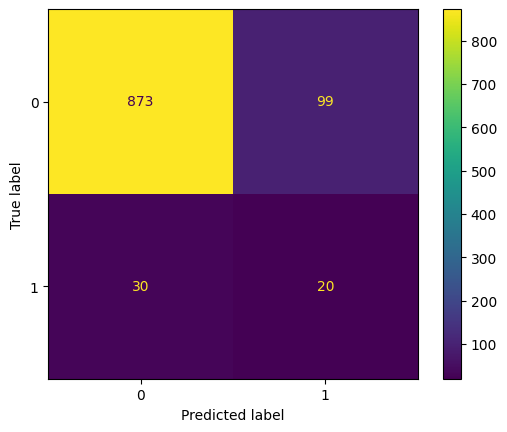

In [5]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred);

Next, we try the Random Forest Classifier.

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       972
           1       0.23      0.34      0.27        50

    accuracy                           0.91      1022
   macro avg       0.60      0.64      0.61      1022
weighted avg       0.93      0.91      0.92      1022



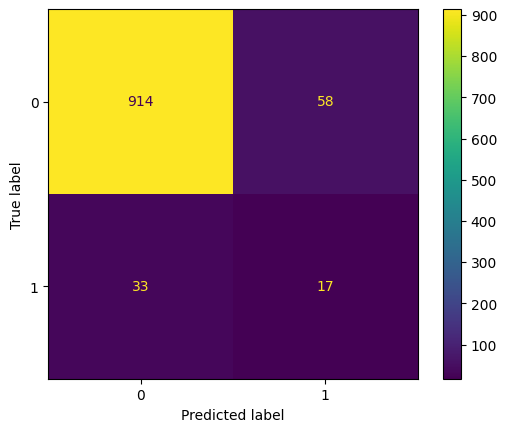

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(
    data=X_train_resampled,
    label=y_train_resampled,
)

val_data = Pool(
    data=X_val,
    label=y_val,
)

test_data = Pool(
    data=X_test,
    label=y_test,
)

catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    random_seed=42,
    verbose=100,
    auto_class_weights="Balanced",
    task_type="GPU",
    eval_metric="F1",
)
catboost_model.fit(train_data, eval_set=val_data, early_stopping_rounds=300)

0:	learn: 0.9102342	test: 0.1890169	best: 0.1890169 (0)	total: 31.2ms	remaining: 31.1s
100:	learn: 0.9834982	test: 0.1668335	best: 0.2129641 (18)	total: 2.44s	remaining: 21.7s
200:	learn: 0.9898241	test: 0.1874605	best: 0.2129641 (18)	total: 4.83s	remaining: 19.2s
300:	learn: 0.9920417	test: 0.1826909	best: 0.2129641 (18)	total: 7.2s	remaining: 16.7s
bestTest = 0.212964086
bestIteration = 18
Shrink model to first 19 iterations.


              precision    recall  f1-score   support

           0       0.97      0.94      0.95       972
           1       0.23      0.34      0.27        50

    accuracy                           0.91      1022
   macro avg       0.60      0.64      0.61      1022
weighted avg       0.93      0.91      0.92      1022



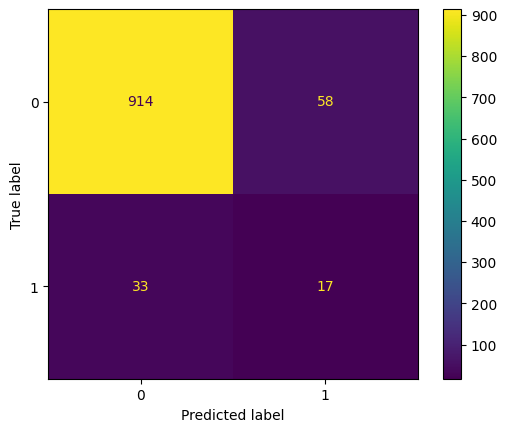

In [8]:
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)